<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C2/RLM_PySpark_BigData_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pyspark
!pip install -q findspark

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype


from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.regression import LinearRegression

In [ ]:
spark = SparkSession.builder.appName("RLM PySpark").getOrCreate()
spark

In [ ]:
url = 'https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/Advertising.csv'
spark.sparkContext.addFile(url)
datos = spark.read.csv(SparkFiles.get('Advertising.csv'),inferSchema=True, header=True)
datos.show(5, truncate=False)

+---+-----+-----+---------+-----+
|_c0|TV   |Radio|Newspaper|Sales|
+---+-----+-----+---------+-----+
|1  |230.1|37.8 |69.2     |22.1 |
|2  |44.5 |39.3 |45.1     |10.4 |
|3  |17.2 |45.9 |69.3     |9.3  |
|4  |151.5|41.3 |58.5     |18.5 |
|5  |180.8|10.8 |58.4     |12.9 |
+---+-----+-----+---------+-----+
only showing top 5 rows



#Informacion Faltante y Columnas innecesarias


In [ ]:
datos_f1 = datos.drop("_c0")
datos_f1.show(5, truncate=False)

+-----+-----+---------+-----+
|TV   |Radio|Newspaper|Sales|
+-----+-----+---------+-----+
|230.1|37.8 |69.2     |22.1 |
|44.5 |39.3 |45.1     |10.4 |
|17.2 |45.9 |69.3     |9.3  |
|151.5|41.3 |58.5     |18.5 |
|180.8|10.8 |58.4     |12.9 |
+-----+-----+---------+-----+
only showing top 5 rows



In [ ]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [ ]:
faltantes(datos_f1)

+---+-----+---------+-----+
| TV|Radio|Newspaper|Sales|
+---+-----+---------+-----+
|  0|    0|        0|    0|
+---+-----+---------+-----+



# Analisis Exploratorio de Datos (EDA)

In [ ]:
datos_f1.describe().show()

+-------+-----------------+------------------+------------------+------------------+
|summary|               TV|             Radio|         Newspaper|             Sales|
+-------+-----------------+------------------+------------------+------------------+
|  count|              200|               200|               200|               200|
|   mean|         147.0425|23.264000000000024|30.553999999999995|14.022500000000003|
| stddev|85.85423631490805|14.846809176168728| 21.77862083852283| 5.217456565710477|
|    min|              0.7|               0.0|               0.3|               1.6|
|    max|            296.4|              49.6|             114.0|              27.0|
+-------+-----------------+------------------+------------------+------------------+



Una forma de establecer variables de utilidad es a través de las matrices de correlación. De este modo con respecto a la salida (Sales), evidenciar que variables presentan el valor absoluto del coeficiente mas alto.

<Axes: >

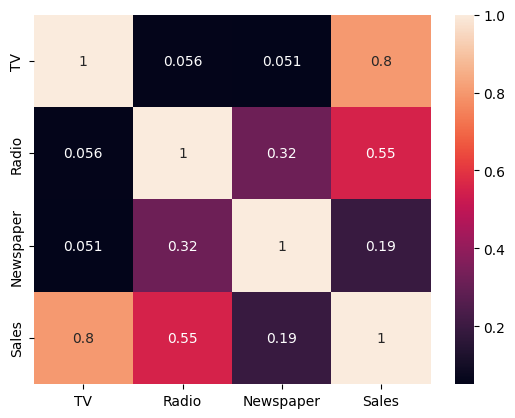

In [ ]:
sns.heatmap(datos_f1.toPandas().corr('spearman'),annot=True)

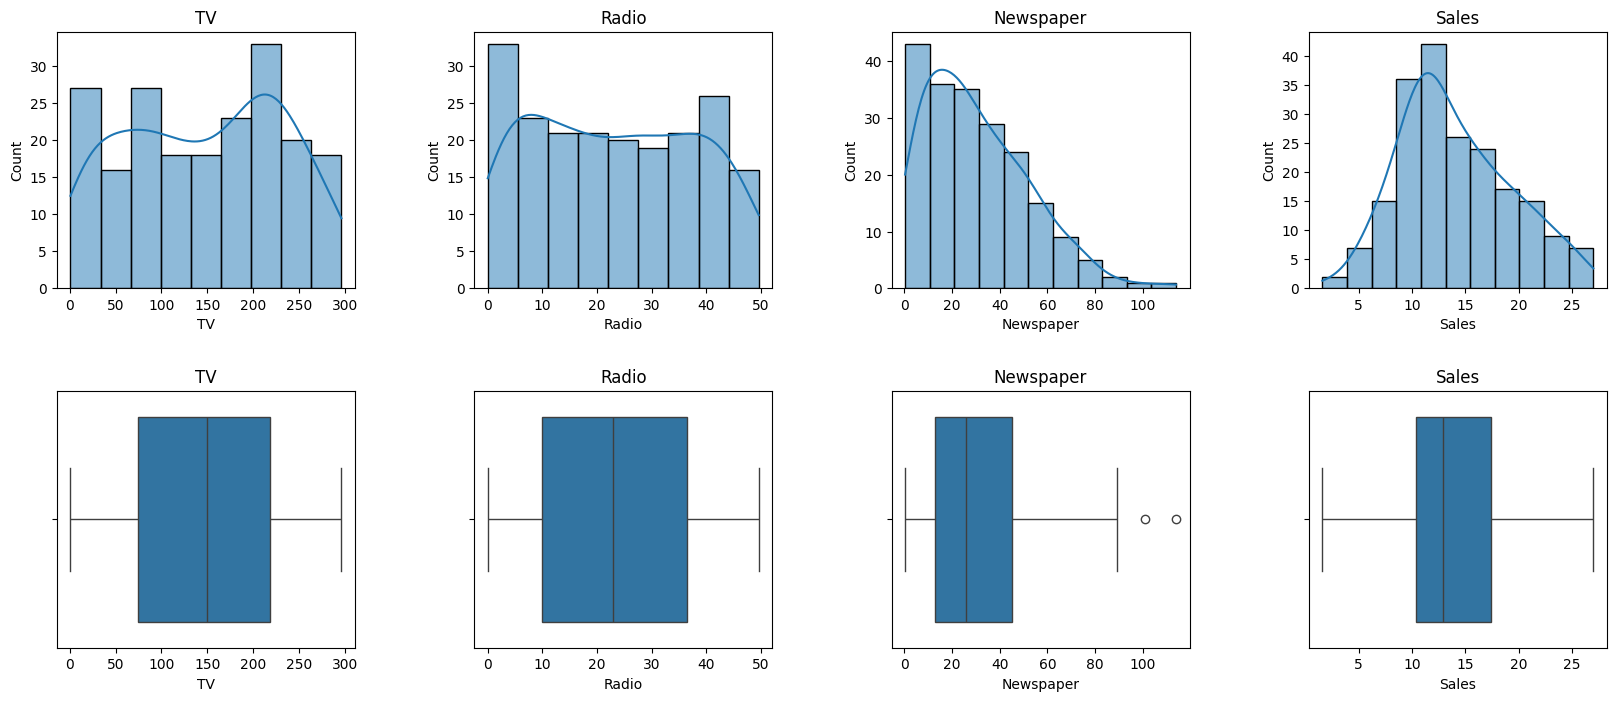

In [ ]:
datos_EDA = datos_f1.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(20, 8))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")

        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico
    elif is_string_dtype(datos_EDA[column]):
        # Conteo en la primera fila
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"Conteo: {column}")

        cat_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()

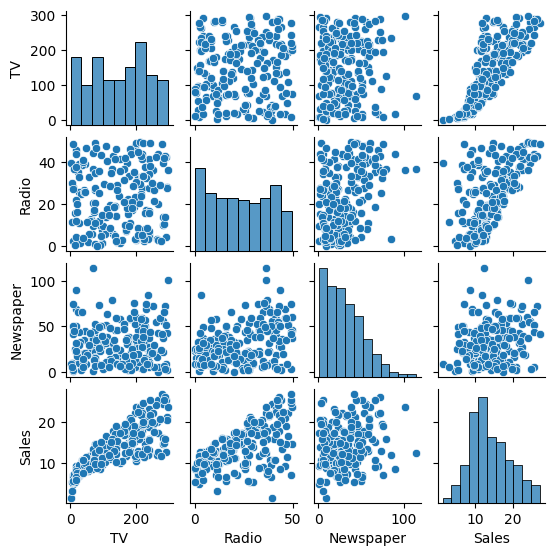

In [ ]:
sns.pairplot(datos_EDA, height=1.4)
plt.show()

# Construcción del Regresor

In [ ]:
assembler = VectorAssembler(
    inputCols=['TV', 'Radio'],
    outputCol="Regresor")

output = assembler.transform(datos_f1)
output.select("Regresor").show(5, truncate=False)

+------------+
|Regresor    |
+------------+
|[230.1,37.8]|
|[44.5,39.3] |
|[17.2,45.9] |
|[151.5,41.3]|
|[180.8,10.8]|
+------------+
only showing top 5 rows



## Normalización o estandarización de variables

Este proceso será necesario cuando los rangos entre las variables excedan las 3 cifras. Es decir, una variable en numeros de 0 a 10 y otra de 0 a 1000.

A pesar de mejorar el rendimiento en algunas ocasiones, se pierde la interpretabilidad del modelo

In [ ]:
#scaler = MinMaxScaler(inputCol='Regresor', min=-1,max=1,outputCol='ScaledReg')
#scaler = StandardScaler(inputCol='Regresor', outputCol='ScaledReg', withMean=True, withStd=True)
#scaler_model = scaler.fit(output)
#output = scaler_model.transform(output)

## División de conjuntos de ajuste (entrenamiento) y prueba

In [ ]:
#datos_reg = output.select('ScaledReg','Sales')
datos_reg = output.select('Regresor','Sales')
train_data,test_data = datos_reg.randomSplit([0.8,0.2],seed=10)

In [ ]:
train_data.describe().show(truncate=False)
test_data.describe().show()

+-------+-----------------+
|summary|Sales            |
+-------+-----------------+
|count  |164              |
|mean   |14.31707317073172|
|stddev |5.104281971893887|
|min    |1.6              |
|max    |27.0             |
+-------+-----------------+

+-------+------------------+
|summary|             Sales|
+-------+------------------+
|  count|                36|
|   mean|12.680555555555554|
| stddev| 5.583998538909163|
|    min|               3.2|
|    max|              26.2|
+-------+------------------+



In [ ]:
#modelo_LR = LinearRegression(labelCol='Sales',featuresCol='ScaledReg')
modelo_LR = LinearRegression(labelCol='Sales',featuresCol='Regresor')
lrModel = modelo_LR.fit(dataset=train_data)
print("Coeficientes: {}".format(lrModel.coefficients))
print('Intercepto: {}'.format(lrModel.intercept))

Coeficientes: [0.04567875909472765,0.1919925711837926]
Intercepto: 2.7926242525140217


## Modelo Ajustado:
$\hat{Sales} =  \hat{\theta}_0 +  \hat{\theta}_1 \cdot TV + \hat{\theta}_2 \cdot Radio $

$\hat{Sales} =  2.792 +  0.046 \cdot TV + 0.192 \cdot Radio $


## Interpretación del modelo
Los principales elementos que hay que interpretar en un modelo de regresión lineal son los coeficientes de los predictores:

* $\theta_0$ es la ordenada en el origen o intercept, se corresponde con el valor esperado de la variable respuesta 𝑦 cuando todos los predictores son cero.

* $\theta_j$ los coeficientes de regresión parcial de cada predictor indican el cambio promedio esperado de la variable respuesta  𝑦 al incrementar en una unidad de la variable predictora  $x_j$, manteniéndose constantes el resto de variables.

# Validación

In [ ]:
y_gorro_test = lrModel.transform(test_data).select("Sales", "prediction").toPandas()
y_gorro_train = lrModel.transform(train_data).select("Sales", "prediction").toPandas()

In [ ]:
test_results = lrModel.evaluate(test_data)
train_results = lrModel.evaluate(train_data)

## Métricas de Rendimiento

### Entrenamiento

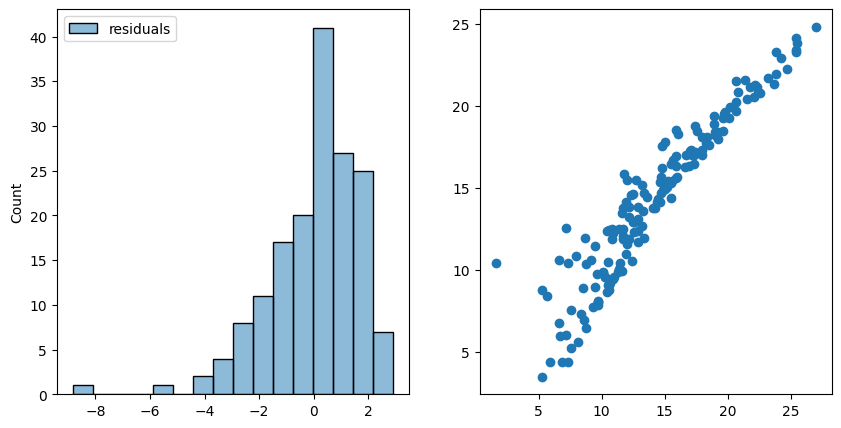

In [ ]:
plt.figure(column, figsize=(10,5))
plt.subplot(1, 2, 1)
sns.histplot(train_results.residuals.toPandas())
plt.subplot(1, 2, 2)
plt.scatter(y_gorro_train['Sales'],y_gorro_train['prediction'])
plt.show()

In [ ]:
print("MSE: {}".format(train_results.meanSquaredError))
print("RMSE: {}".format(train_results.rootMeanSquaredError))
print("MAE: {}".format(train_results.meanAbsoluteError))
print("R2: %f" % train_results.r2)

MSE: 2.777003924652034
RMSE: 1.6664344945577771
MAE: 1.2333531403316627
R2: 0.892758


### Prueba

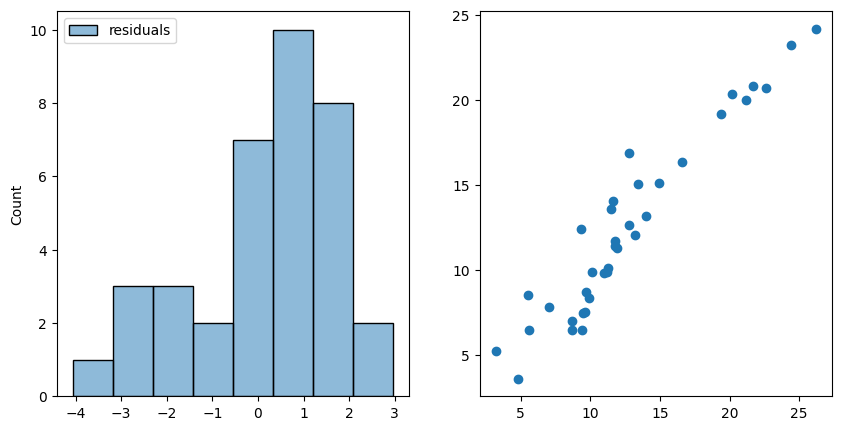

In [ ]:
plt.figure(column, figsize=(10,5))
plt.subplot(1, 2, 1)
sns.histplot(test_results.residuals.toPandas())
plt.subplot(1, 2, 2)
plt.scatter(y_gorro_test['Sales'],y_gorro_test['prediction'])
plt.show()

In [ ]:
print("MSE: {}".format(test_results.meanSquaredError))
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MAE: {}".format(test_results.meanAbsoluteError))
print("r2: %f" % test_results.r2)

MSE: 2.850603203425078
RMSE: 1.6883729455973517
MAE: 1.3896030162986879
r2: 0.905967
